# 04. SVM Modeling
In this stage, we evaluate the performance of the Support Vector Machine (SVM) algorithm several experimental configurations.

### Experimental Schemes:
We implemented **4 distinct schemes** by combining various parameters to find the most robust model for classifying TikTok Shop sentiments:
* **Data Split:** 80:20
* **Oversampling:** with and without ADASYN.
* **SVM Kernels:** Linear.
* **Multi-class Strategy:** One-vs-One (OvO) and One-vs-Rest (OvR).

### Steps
1. **Label Encoding** Converting text labels into numerical values.
2. **Feature Extraction** (TF-IDF Unigram) Transforming text into numerical vectors.
3. **Data Split** Partitioning data into training and testing sets.
4. **Oversampling**  ([ADASYN](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.ADASYN.html)) Handling class imbalance.
5. **Hyperparameter Tuning** ([GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)) Optimizing hyperparameters.
6. **Training** Training [SVM](https://scikit-learn.org/stable/modules/svm.html) model using data train.
7. **Testing** Testing SVM model using data test.
8. **Saving Model** Exporting model as [pickle](https://docs.python.org/3/library/pickle.html#examples) file.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from imblearn.over_sampling import ADASYN
from sklearn.base import clone

## Load Data

In [ ]:
DATA_PATH = '../data/'
MODEL_PATH = '../models/'
df = pd.read_csv(DATA_PATH + 'labeled_sample.csv', sep=";")

## Label Encoding

In [16]:
le = LabelEncoder()
df['label_numerical'] = le.fit_transform(df['label'])
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"Mapping Label: {label_mapping}")

Mapping Label: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}


## Feature Extraction TF-IDF

In [17]:
tfidf = TfidfVectorizer(ngram_range=(1, 1)) # Unigram
X_tfidf = tfidf.fit_transform(df['full_text'])
y = df['label_numerical']

with open(MODEL_PATH + 'tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

## Data Split

In [18]:
X_dense = X_tfidf.toarray()

X_train, X_test, y_train, y_test = train_test_split(
    X_dense, y, test_size=0.2, random_state=72, stratify=y
)

## Oversampling with ADASYN

In [19]:
ada = ADASYN(random_state=42)
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)

print(f"Original Train Set: {X_train.shape[0]} samples")
print(f"ADASYN Train Set: {X_train_ada.shape[0]} samples")

Original Train Set: 1426 samples
ADASYN Train Set: 2075 samples


## Hyperparameter Tuning using GridSearch

In [ ]:
print("\n[INFO] Finding the best hyperparameter (C)...")
param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear']}
grid_search = GridSearchCV(SVC(), param_grid, cv=10, scoring='f1_macro')
grid_search.fit(X_train, y_train)

best_c = grid_search.best_params_['C']
print(f"Best Parameter C: {best_c}")


[INFO] Mencari Hyperparameter Terbaik (C)...
Best Parameter C: 1


## Evaluation Function

In [21]:
def evaluate_model(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    print(f"\n{'='*20} {title} {'='*20}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(5, 5))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                            display_labels=le.classes_, 
                                            cmap='Blues', ax=ax, colorbar=False)
    plt.title(f"CM: {title}")
    plt.show()
    return accuracy_score(y_test, y_pred)

## Training

In [22]:
svm_core = SVC(C=best_c, kernel='linear')

# SVM Linear without ADASYN (OvO & OvR)
model_l1 = OneVsOneClassifier(svm_core).fit(X_train, y_train)
model_l2 = OneVsRestClassifier(svm_core).fit(X_train, y_train)

# SVM Linear with ADASYN (OvO & OvR)
model_la1 = OneVsOneClassifier(svm_core).fit(X_train_ada, y_train_ada)
model_la2 = OneVsRestClassifier(svm_core).fit(X_train_ada, y_train_ada)

## Testing


==================== Linear OvO ====================
              precision    recall  f1-score   support

    negative       0.63      0.49      0.55        98
     neutral       0.62      0.80      0.70       175
    positive       0.66      0.44      0.53        84

    accuracy                           0.63       357
   macro avg       0.64      0.58      0.59       357
weighted avg       0.63      0.63      0.62       357



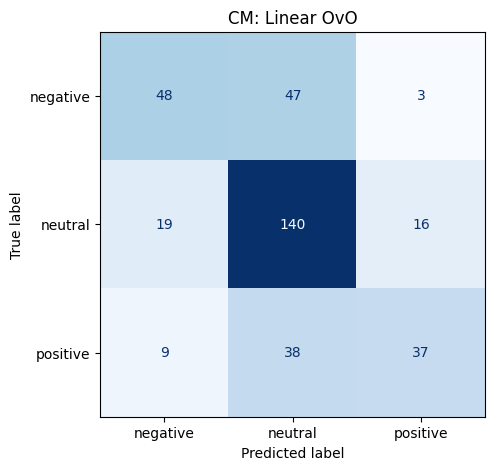


==================== Linear OvR ====================
              precision    recall  f1-score   support

    negative       0.65      0.54      0.59        98
     neutral       0.66      0.81      0.72       175
    positive       0.72      0.52      0.61        84

    accuracy                           0.67       357
   macro avg       0.68      0.62      0.64       357
weighted avg       0.67      0.67      0.66       357



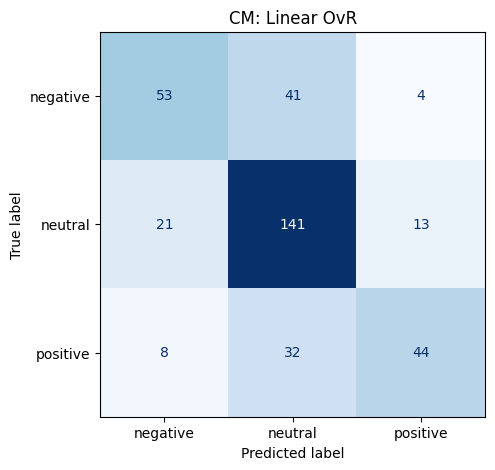


==================== Linear + ADASYN OvO ====================
              precision    recall  f1-score   support

    negative       0.60      0.65      0.63        98
     neutral       0.71      0.66      0.68       175
    positive       0.57      0.61      0.59        84

    accuracy                           0.64       357
   macro avg       0.63      0.64      0.63       357
weighted avg       0.65      0.64      0.65       357



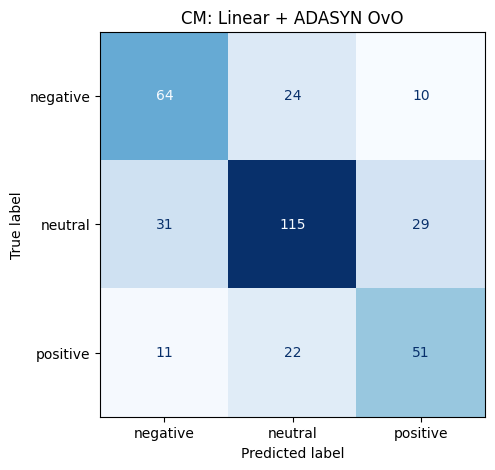


==================== Linear + ADASYN OvR ====================
              precision    recall  f1-score   support

    negative       0.58      0.69      0.63        98
     neutral       0.74      0.59      0.66       175
    positive       0.54      0.63      0.58        84

    accuracy                           0.63       357
   macro avg       0.62      0.64      0.62       357
weighted avg       0.65      0.63      0.63       357



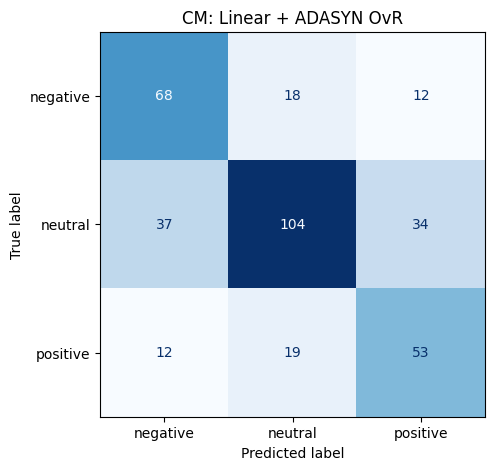

In [23]:
results = {}
results['Linear_OvO'] = evaluate_model(model_l1, X_test, y_test, "Linear OvO")
results['Linear_OvR'] = evaluate_model(model_l2, X_test, y_test, "Linear OvR")
results['Linear_ADASYN_OvO'] = evaluate_model(model_la1, X_test, y_test, "Linear + ADASYN OvO")
results['Linear_ADASYN_OvR'] = evaluate_model(model_la2, X_test, y_test, "Linear + ADASYN OvR")

## Summary

In [24]:
df_results = pd.DataFrame(list(results.items()), columns=['Model Schema', 'Accuracy'])
print("\nACCURACY SUMMARY:")
print(df_results.sort_values(by='Accuracy', ascending=False))


ACCURACY SUMMARY:
        Model Schema  Accuracy
1         Linear_OvR  0.666667
2  Linear_ADASYN_OvO  0.644258
0         Linear_OvO  0.630252
3  Linear_ADASYN_OvR  0.630252


In [ ]:
# Saving Model
with open(MODEL_PATH + 'model_L1.pkl', 'wb') as f:
    pickle.dump(model_l1, f)
with open(MODEL_PATH + 'model_L2.pkl', 'wb') as f:
    pickle.dump(model_l2, f)
with open(MODEL_PATH + 'model_LA1.pkl', 'wb') as f:
    pickle.dump(model_la1, f)
with open(MODEL_PATH + 'model_LA2.pkl', 'wb') as f:
    pickle.dump(model_la2, f)